In [1]:
import numpy as np
import librosa
from scipy import signal
import json
import string
#import threading
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt

In [2]:
def istft_reconstruction_from_complex(real, imag, hop_length=160, win_length=400, length=65535):
    spec = real + 1j*imag
    wav = librosa.istft(spec, hop_length=hop_length, win_length=win_length, length=length)
    return np.clip(wav, -1., 1.)
def _samples_to_stft_frames(samples, size, shift):
    """
    Calculates STFT frames from samples in time domain.
    :param samples: Number of samples in time domain.
    :param size: FFT size.
    :param shift: Hop in samples.
    :return: Number of STFT frames.
    """

    return np.ceil((samples - size + shift) / shift).astype(np.int64)


def segment_axis(a, length, overlap=0, axis=None, end='cut', endvalue=0):
    """Generate a new array that chops the given array along the given axis into overlapping frames.

    example:
    >>> segment_axis(np.arange(10), 4, 2)
    array([[0, 1, 2, 3],
           [2, 3, 4, 5],
           [4, 5, 6, 7],
           [6, 7, 8, 9]])

    arguments:
    a       The array to segment
    length  The length of each frame
    overlap The number of array elements by which the frames should overlap
    axis    The axis to operate on; if None, act on the flattened array
    end     What to do with the last frame, if the array is not evenly
            divisible into pieces. Options are:

            'cut'   Simply discard the extra values
            'wrap'  Copy values from the beginning of the array
            'pad'   Pad with a constant value

    endvalue    The value to use for end='pad'

    The array is not copied unless necessary (either because it is
    unevenly strided and being flattened or because end is set to
    'pad' or 'wrap').
    """

    if axis is None:
        a = np.ravel(a)  # may copy
        axis = 0

    l = a.shape[axis]

    if overlap >= length: raise ValueError(
            "frames cannot overlap by more than 100%")
    if overlap < 0 or length <= 0: raise ValueError(
            "overlap must be nonnegative and length must be positive")

    if l < length or (l - length) % (length - overlap):
        if l > length:
            roundup = length + (1 + (l - length) // (length - overlap)) * (
                length - overlap)
            rounddown = length + ((l - length) // (length - overlap)) * (
                length - overlap)
        else:
            roundup = length
            rounddown = 0
        assert rounddown < l < roundup
        assert roundup == rounddown + (length - overlap) or (
            roundup == length and rounddown == 0)
        a = a.swapaxes(-1, axis)

        if end == 'cut':
            a = a[..., :rounddown]
        elif end in ['pad', 'wrap']:  # copying will be necessary
            s = list(a.shape)
            s[-1] = roundup
            b = np.empty(s, dtype=a.dtype)
            b[..., :l] = a
            if end == 'pad':
                b[..., l:] = endvalue
            elif end == 'wrap':
                b[..., l:] = a[..., :roundup - l]
            a = b

        a = a.swapaxes(-1, axis)

    l = a.shape[axis]
    if l == 0: raise ValueError(
            "Not enough data points to segment array in 'cut' mode; "
            "try 'pad' or 'wrap'")
    assert l >= length
    assert (l - length) % (length - overlap) == 0
    n = 1 + (l - length) // (length - overlap)
    s = a.strides[axis]
    newshape = a.shape[:axis] + (n, length) + a.shape[axis + 1:]
    newstrides = a.strides[:axis] + ((length - overlap) * s, s) + a.strides[
                                                                  axis + 1:]

    if not a.flags.contiguous:
        a = a.copy()
        newstrides = a.strides[:axis] + ((length - overlap) * s, s) + a.strides[
                                                                      axis + 1:]
        return np.ndarray.__new__(np.ndarray, strides=newstrides,
                                  shape=newshape, buffer=a, dtype=a.dtype)

    try:
        return np.ndarray.__new__(np.ndarray, strides=newstrides,
                                  shape=newshape, buffer=a, dtype=a.dtype)
    except TypeError or ValueError:
        warnings.warn("Problem with ndarray creation forces copy.")
        a = a.copy()
        # Shape doesn't change but strides does
        newstrides = a.strides[:axis] + ((length - overlap) * s, s) + a.strides[
                                                                      axis + 1:]
        return np.ndarray.__new__(np.ndarray, strides=newstrides,
                                  shape=newshape, buffer=a, dtype=a.dtype)


def _stft_frames_to_samples(frames, size, shift):
    """
    Calculates samples in time domain from STFT frames
    :param frames: Number of STFT frames.
    :param size: FFT size.
    :param shift: Hop in samples.
    :return: Number of samples in time domain.
    """
    return frames * shift + size - shift


def stft(time_signal, time_dim=None, size=512, shift=256,
         window=signal.blackman, fading=True, window_length=None):
    """
    Calculates the short time Fourier transformation of a multi channel multi
    speaker time signal. It is able to add additional zeros for fade-in and
    fade out and should yield an STFT signal which allows perfect
    reconstruction.

    :param time_signal: multi channel time signal.
    :param time_dim: Scalar dim of time.
        Default: None means the biggest dimension
    :param size: Scalar FFT-size.
    :param shift: Scalar FFT-shift. Typically shift is a fraction of size.
    :param window: Window function handle.
    :param fading: Pads the signal with zeros for better reconstruction.
    :param window_length: Sometimes one desires to use a shorter window than
        the fft size. In that case, the window is padded with zeros.
        The default is to use the fft-size as a window size.
    :return: Single channel complex STFT signal
        with dimensions frames times size/2+1.
    """
    if time_dim is None:
        time_dim = np.argmax(time_signal.shape)

    # Pad with zeros to have enough samples for the window function to fade.
    if fading:
        pad = [(0, 0)] * time_signal.ndim
        pad[time_dim] = [size - shift, size - shift]
        time_signal = np.pad(time_signal, pad, mode='constant')

    # Pad with trailing zeros, to have an integral number of frames.
    frames = _samples_to_stft_frames(time_signal.shape[time_dim], size, shift)
    samples = _stft_frames_to_samples(frames, size, shift)
    pad = [(0, 0)] * time_signal.ndim
    pad[time_dim] = [0, samples - time_signal.shape[time_dim]]
    time_signal = np.pad(time_signal, pad, mode='constant')

    if window_length is None:
        window = window(size)
    else:
        window = window(window_length)
        window = np.pad(window, (0, size - window_length), mode='constant')

    time_signal_seg = segment_axis(time_signal, size,
                                   size - shift, axis=time_dim)

    letters = string.ascii_lowercase
    mapping = letters[:time_signal_seg.ndim] + ',' + letters[time_dim + 1] \
              + '->' + letters[:time_signal_seg.ndim]

    return rfft(np.einsum(mapping, time_signal_seg, window),
                axis=time_dim + 1)

def _biorthogonal_window_loopy(analysis_window, shift):
    """
    This version of the synthesis calculation is as close as possible to the
    Matlab impelementation in terms of variable names.

    The results are equal.

    The implementation follows equation A.92 in
    Krueger, A. Modellbasierte Merkmalsverbesserung zur robusten automatischen
    Spracherkennung in Gegenwart von Nachhall und Hintergrundstoerungen
    Paderborn, Universitaet Paderborn, Diss., 2011, 2011
    """
    fft_size = len(analysis_window)
    assert np.mod(fft_size, shift) == 0
    number_of_shifts = len(analysis_window) // shift

    sum_of_squares = np.zeros(shift)
    for synthesis_index in range(0, shift):
        for sample_index in range(0, number_of_shifts + 1):
            analysis_index = synthesis_index + sample_index * shift

            if analysis_index + 1 < fft_size:
                sum_of_squares[synthesis_index] \
                    += analysis_window[analysis_index] ** 2

    sum_of_squares = np.kron(np.ones(number_of_shifts), sum_of_squares)
    synthesis_window = analysis_window / sum_of_squares / fft_size
    return synthesis_window

def istft(stft_signal, size=512, shift=256,
          window=signal.blackman, fading=True, window_length=None):
    """
    Calculated the inverse short time Fourier transform to exactly reconstruct
    the time signal.

    :param stft_signal: Single channel complex STFT signal
        with dimensions frames times size/2+1.
    :param size: Scalar FFT-size.
    :param shift: Scalar FFT-shift. Typically shift is a fraction of size.
    :param window: Window function handle.
    :param fading: Removes the additional padding, if done during STFT.
    :param window_length: Sometimes one desires to use a shorter window than
        the fft size. In that case, the window is padded with zeros.
        The default is to use the fft-size as a window size.
    :return: Single channel complex STFT signal
    :return: Single channel time signal.
    """
    print(f'Shape of stft_signal is:{stft_signal.shape[1]}')
    a = size // 2 + 1
    print(f'size // 2 + 1 is: ={a}')
    assert stft_signal.shape[1] == size // 2 +1

    if window_length is None:
        window = window(size)
    else:
        window = window(window_length)
        window = np.pad(window, (0, size - window_length), mode='constant')

    window = _biorthogonal_window_loopy(window, shift)

    # Why? Line created by Hai, Lukas does not know, why it exists.
    window *= size

    time_signal = scipy.zeros(stft_signal.shape[0] * shift + size - shift)

    for j, i in enumerate(range(0, len(time_signal) - size + shift, shift)):
        time_signal[i:i + size] += window * np.real(irfft(stft_signal[j]))

    # Compensate fade-in and fade-out
    if fading:
        time_signal = time_signal[
                      size - shift:len(time_signal) - (size - shift)]

    return time_signal


def compute_tdoa(r_u, r_v, theta, fs, c):
    r_u = np.array(r_u)
    r_v = np.array(r_v)
    theta = np.array(theta)
    return fs / c * np.dot((r_u - r_v), theta)


def steering_vector(tdoa, f, N):
    return np.exp(1j * 2 * np.pi * f * tdoa / N)


def gain_function(delta_tdoa, alpha, beta):
    return np.exp(-alpha * (delta_tdoa - beta)) / (1 + np.exp(-alpha * (delta_tdoa - beta)))


def cirm(y_stft, s_stft, r_u, r_v, theta_t, theta_i, fs, c, alpha, beta, K=10, C=0.1, flat=True):
    tdoa_uv = compute_tdoa(r_u, r_v, theta_t, fs, c)
    delta_tdoa_uv = compute_tdoa(r_u, r_v, theta_t - theta_i, fs, c)

    f = np.arange(y_stft.shape[0])
    N = y_stft.shape[1]

    A_uv = steering_vector(tdoa_uv, f[:, None], N)
    A_uv = A_uv[:, :, None]
    print(f'Shape of A_uv, steering vector is: {A_uv.shape}')
    Y_uv = A_uv * y_stft * np.conj(y_stft)

    G_uv = gain_function(delta_tdoa_uv, alpha, beta)

    S_u = np.abs(s_stft)
    I_u = np.abs(y_stft - s_stft)
    B_u = np.zeros_like(S_u)

    M_uv = (S_u ** 2 + G_uv * I_u ** 2) / (S_u ** 2 + I_u ** 2 + B_u ** 2)

    if flat:
        return M_uv
    else:
        return K * ((1 - np.exp(-C * M_uv)) / (1 + np.exp(-C * M_uv)))

### Useful functions

In [3]:
def main_():
    # Load the coordinates from the JSON file
    mic_coordinates = [
        [1.78, 1.75, 1.70],
        [1.75, 1.78, 1.70],
        [1.72, 1.75, 1.70],
        [1.75, 1.72, 1.70]
    ]
    noise_location = [2.595, 1.976, 1.7]
    target_location = [2.625, 1.75, 1.7]

    # Load your audio files (paths need to be adjusted to your environment)
    target_0, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00069_mic0_voice0.wav")
    target_1, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00069_mic1_voice0.wav")
    target_2, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00069_mic2_voice0.wav")
    target_3, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00069_mic3_voice0.wav")

    noise_0, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00085_mic0_voice1.wav")
    noise_1, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00085_mic1_voice1.wav")
    noise_2, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00085_mic2_voice1.wav")
    noise_3, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00085_mic3_voice1.wav")

    mix_0, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00069_mic0_voice0_and_00085_mic0_voice1_mixed.wav")
    mix_1, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00069_mic1_voice0_and_00085_mic1_voice1_mixed.wav")
    mix_2, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00069_mic2_voice0_and_00085_mic2_voice1_mixed.wav")
    mix_3, sr = librosa.load(
        "E:/AV-speech-separation/data/VoxCeleb2/results/simulated/id04366_8L6xm1OyG0w_00069VSid05594_RcwKkgqgPSA_00085/00069_mic3_voice0_and_00085_mic3_voice1_mixed.wav")

    multi_channel_mix = np.stack((mix_0, mix_1, mix_2, mix_3), axis=0)
    multi_channel_clean = np.stack((target_0, target_1, target_2, target_3), axis=0)
    multi_channel_noise = np.stack((noise_0, noise_1, noise_2, noise_3), axis=0)

    # Compute STFT
    Y = stft(multi_channel_mix, time_dim=1).transpose((1, 0, 2))
    stft_clean = stft(multi_channel_clean, time_dim=1).transpose((1, 0, 2))
    print(f'Shape of mix is: {Y.shape}')
    print(f'Shape of stft_clean is: {stft_clean.shape}')
    stft_noise = stft(multi_channel_noise, time_dim=1).transpose((1, 0, 2))

    # Extract parameters for calculation
    r_u = mic_coordinates[0]  # Example: using the first mic position
    r_v = mic_coordinates[1]  # Example: using the second mic position
    theta_t = target_location  # Target location
    theta_i = noise_location  # Noise location

    # Sampling frequency and speed of sound
    fs = 16000
    c = 343

    # Gain function parameters
    alpha = 0.5
    beta = 0
    r_u = np.array(r_u)
    r_v = np.array(r_v)
    theta_i = np.array(theta_i)
    theta_t = np.array(theta_t)
    # Compute the cIRM
    irm_clean = cirm(Y, stft_clean, r_u, r_v, theta_t, theta_i, fs, c, alpha, beta)
    irm_noise = cirm(Y, stft_noise, r_u, r_v, theta_i, theta_t, fs, c, alpha, beta)

    # Calculate the magnitude of the IRM
    irm_magnitude_clean = np.abs(irm_clean)
    irm_magnitude_noise = np.abs(irm_noise)

    # Print the shape and the IRM magnitude
    return irm_magnitude_clean, irm_magnitude_noise

### Loading files

In [6]:
if __name__ == "__main__":
    irm_magnitude_clean, irm_magnitude_noise = main()

Shape of mix is: (454, 4, 257)
Shape of stft_clean is: (454, 4, 257)
Shape of A_uv, steering vector is: (454, 1, 1)
Shape of A_uv, steering vector is: (454, 1, 1)


C:\Users\yosra\AppData\Local\Temp\ipykernel_2360\3843995221.py:167: DeprecationWarning: Importing blackman from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackman' or the convenience function 'scipy.signal.get_window' instead.
  window = window(size)


In [7]:
def plot_irm_magnitude(irm_magnitude, title = 'Clean IRM Magnitude'):
    plt.figure(figsize=(10, 6))
    plt.imshow(irm_magnitude.T, aspect='auto', origin='lower', interpolation='nearest')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel('Time Frames')
    plt.ylabel('Frequency Bins')
    plt.show()

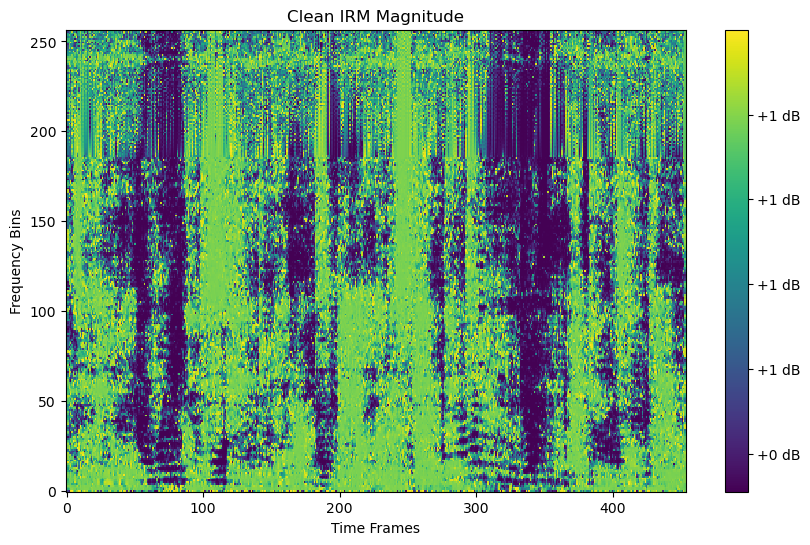

In [9]:
plot_irm_magnitude(irm_magnitude_clean[:,1,:])

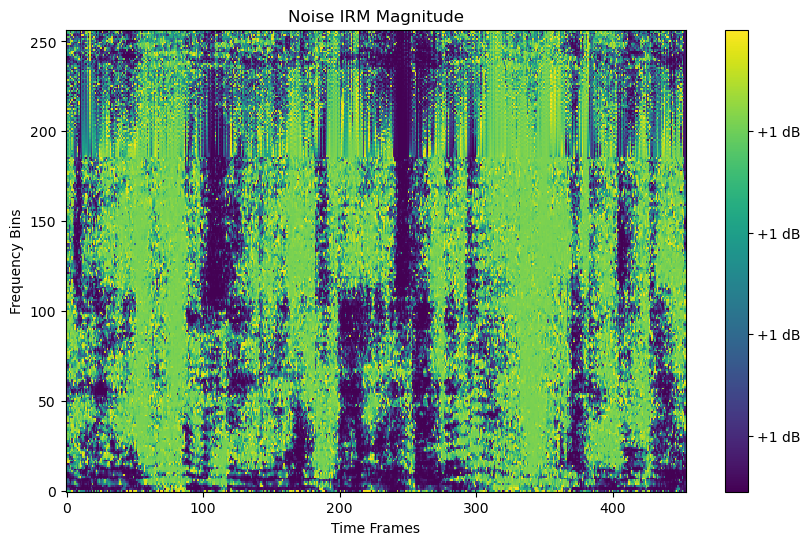

In [10]:
plot_irm_magnitude(irm_magnitude_noise[:,1,:], 'Noise IRM Magnitude')